In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy as sp
import pymaster as nmt
from tqdm import tqdm
import obs_cov

In [2]:
nside = 64
lmax = 3*nside-1
npix = 12*nside**2
l = np.arange(lmax+1)
c2d = l*(l+1)/2/np.pi

hits = hp.read_map(f'obsmat_nside{nside}/out/0/filterbin_hits.fits')
non_zero = np.where(hits!=0)[0]

mask = np.zeros_like(hits)
mask[non_zero] = 1
mask_apo = nmt.mask_apodization(mask, 10, 'C2')
R_unapo = sp.sparse.load_npz(f'obsmat_nside{nside}/obsmat.npz')
R_QU_unapo = R_unapo[npix:, npix:]

Z = sp.sparse.diags_array(mask_apo)
ZZ = sp.sparse.block_diag([Z, Z, Z])

R = ZZ @ R_unapo
# R = R_unapo
R_QU = R[npix:, npix:]

Cl_EEonly = obs_cov.get_Cl(nside, 'E')
Cl_BBonly = obs_cov.get_Cl(nside, 'B')

/scratch/yuyang/filterbin/obs_cov.py:12: RuntimeWarning: divide by zero encountered in divide
  C_l = 1/l**2


In [3]:
# nmc = 1024
# C_mc = np.zeros((2*npix, 2*npix))

# for i in range(nmc):
#     np.random.seed(i)
#     m = hp.synfast(Cl_EEonly, nside, new=True)    
#     m -= np.mean(m)
#     m_QU = np.concatenate([m[1], m[2]])
#     C_mc += np.outer(m_QU, m_QU)

# C_mc /= nmc

In [4]:
# C_E = obs_cov.C_ana(nside, Cl_EEonly, mask)
# C_B = obs_cov.C_ana(nside, Cl_BBonly, mask)

# sp.sparse.save_npz(f'C_E_{nside}', C_E)
# sp.sparse.save_npz(f'C_B_{nside}', C_B)

In [5]:
# C_E = sp.sparse.load_npz(f'C_E_{nside}.npz')
# C_B = sp.sparse.load_npz(f'C_B_{nside}.npz')

In [6]:
# obs_C_E = R_QU @ C_E @ R_QU.T
# obs_C_B = R_QU @ C_B @ R_QU.T

In [7]:
# sp.sparse.save_npz(f'obs_C_E_{nside}', obs_C_E)
# sp.sparse.save_npz(f'obs_C_B_{nside}', obs_C_B)

In [8]:
# obs_C_E = sp.sparse.load_npz(f'obs_C_E_{nside}.npz')
# obs_C_B = sp.sparse.load_npz(f'obs_C_B_{nside}.npz')

In [9]:
# # sparse
# diag_E = obs_C_E.diagonal()
# diag_B = obs_C_B.diagonal()

# sigma = (np.mean(diag_E[diag_E!=0]) + np.mean(diag_B[diag_B!=0])) / 2 /1000
# factor = sp.sparse.identity(obs_C_E.shape[0])*sigma**2

In [10]:
# eigs, v = sp.sparse.linalg.eigsh( obs_C_B+factor , 2048, obs_C_E+factor )

In [11]:
# #dense
# diag_E = np.diag(obs_C_E.toarray())
# diag_B = np.diag(obs_C_B.toarray())

# sigma = (np.mean(diag_E[diag_E!=0]) + np.mean(diag_B[diag_B!=0])) /2 /1000
# factor = np.eye(C_E.shape[0]) * sigma **2

# eigs, v = sp.linalg.eigh(obs_C_B.toarray()+factor, obs_C_E.toarray()+factor)

In [12]:
# plt.plot(eigs, marker='.', linestyle='None')
# plt.semilogy()
# plt.grid()
# print(eigs[0])

In [13]:
# ambi = 0
# for eig in eigsh:
#     if np.isclose(eig, 1):
#         ambi += 1
# ambi / len(eigs)

In [14]:
# # purification
# cut = 1.02
# pass_cut = np.where(eigs >= cut)[0]

In [15]:
# pure_b = v[:, pass_cut]
# pure_b.shape

In [16]:
# pure_b[:,0] @ pure_b[:,-1]

In [17]:
# mask_QU = np.concatenate([mask, mask])
# zeros = np.where(mask_QU==0)[0]

# for i in range(pure_b.shape[1]):    
#     pure_b[:,i][zeros] = 0
#     pure_b[:,i] /= np.linalg.norm(pure_b[:,i], axis=0)

# pure_b[:,0] @ pure_b[:,-1]

In [18]:
# hp.mollview(pure_b[:,-1].reshape(2, npix)[0])

In [19]:
# #Sparse
# pure_b = sp.sparse.csr_array(pure_b)
# pure_b

In [20]:
# pi_b = pure_b @ sp.sparse.linalg.inv(pure_b.T @ pure_b) @ pure_b.T
# # pi_b = pure_b @ pure_b.T
# pi_b

In [21]:
# sp.sparse.linalg.eigsh(pi_b, 3, return_eigenvectors=False)

In [22]:
#dense
# pi_b = pure_b @ pure_b.T
# pi_b = pure_b @ np.linalg.inv(pure_b.T @ pure_b) @ pure_b.T
# e,_ = sp.linalg.eigh(pi_b)
# e

In [23]:
# sp.sparse.save_npz(f'pi_b_{nside}', pi_b)

In [24]:
pi_b = sp.sparse.load_npz('pi_b_64.npz')

In [25]:
m = hp.synfast(Cl_BBonly, nside, new=True)
pure_QU = (pi_b @ m[1:].flatten()).reshape(2,npix)

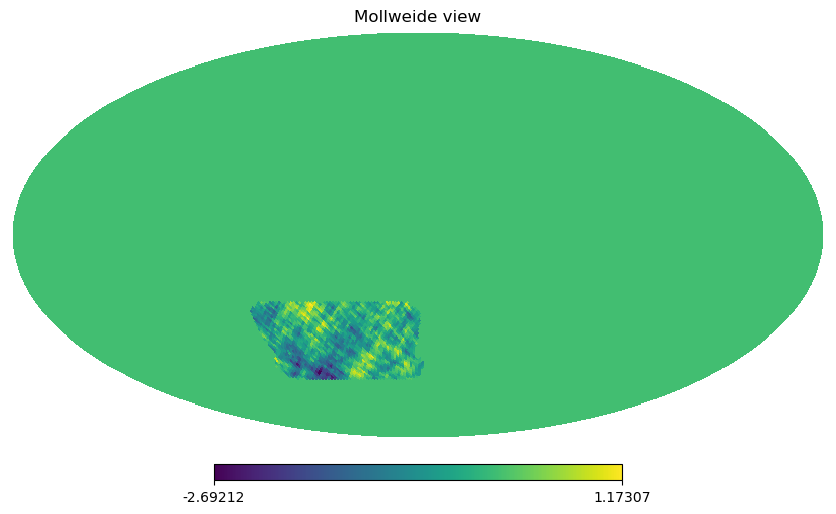

In [26]:
hp.mollview(mask*m[1])

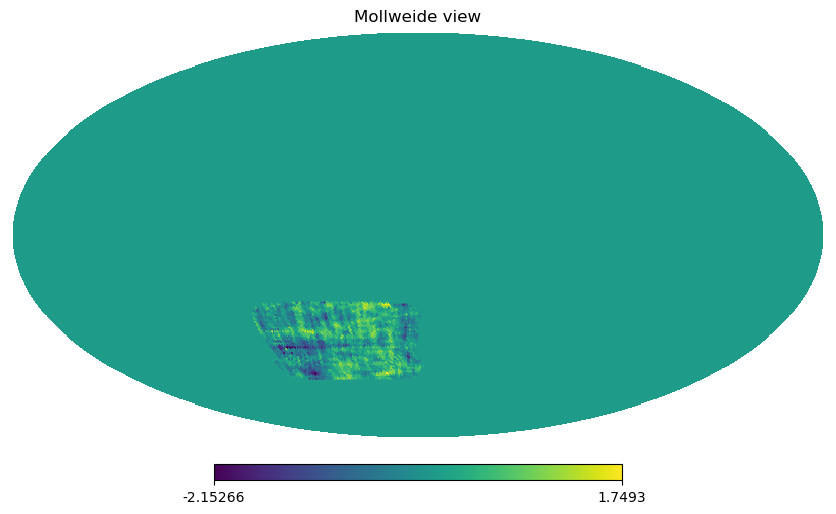

In [27]:
hp.mollview(pure_QU[1])

In [28]:
ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
c2d = ell_input*(ell_input+1)/2/np.pi
# input_cls = np.array([TT, EE, np.zeros_like(EE), TE]) #no BB
input_cls = np.array([TT, EE, BB, TE]) 
input_cls /= c2d 
for c in input_cls: c[0] = 0 
input_cls = input_cls[:,:lmax+1]
c2d = c2d[:lmax+1]

input_cls_noBB = np.copy(input_cls)
input_cls_noBB[2] = np.zeros(lmax+1)

input_cls_noEE = np.copy(input_cls)
input_cls_noEE[1] = np.zeros(lmax+1)
input_cls_noEE[3] = np.zeros(lmax+1)

w2 = np.sum(mask_apo**2)/np.sum(mask)
fsky = np.sum(mask)/npix

/tmp/ipykernel_40391/1965576218.py:5: RuntimeWarning: invalid value encountered in divide
  input_cls /= c2d


In [29]:
sigmab = hp.nside2resol(nside)
fwhm = (8*np.log(2))**0.5 * sigmab
# fwhm = np.deg2rad(17/60)
bl = hp.gauss_beam(fwhm, lmax) 

In [30]:
#filter transfer
nmc = 1024

pcl = np.zeros(lmax+1)
pcl_pure = np.zeros(lmax+1)
cl = np.zeros(lmax+1) 

for i in tqdm(range(nmc)):
    np.random.seed(i+1000)
    m = hp.synfast(input_cls_noEE, nside, new=True)
    cl += hp.anafast(m)[2]

    m_smooth = hp.smoothing(m, fwhm)
    obs_m = (R @ m_smooth.flatten()).reshape(3, npix)    
    pcl += hp.anafast(obs_m)[2]

    obs_m[1:] = (pi_b @ obs_m[1:].flatten()).reshape(2, npix)
    pcl_pure += hp.anafast(obs_m)[2]
    
pcl /= nmc
pcl_pure /= nmc
cl /= nmc

100%|██████████████████████████████████████████| 1024/1024 [03:33<00:00,  4.80it/s]


/tmp/ipykernel_40391/922142926.py:2: RuntimeWarning: invalid value encountered in divide
  fl = pcl / (bl**2 * input_cls[2] * fsky*w2)
/tmp/ipykernel_40391/922142926.py:4: RuntimeWarning: invalid value encountered in divide
  fl_pure = pcl_pure / (bl**2 * input_cls[2] * fsky*w2)


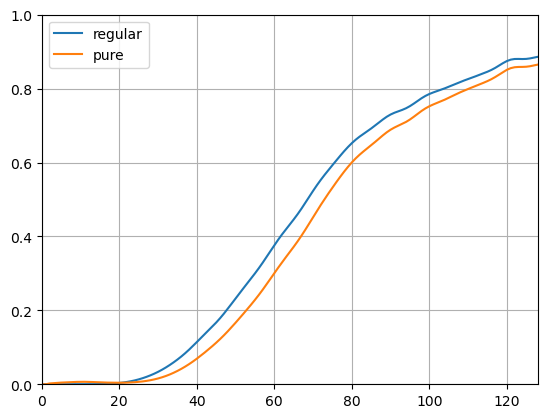

In [31]:
#reload(mylib)
fl = pcl / (bl**2 * input_cls[2] * fsky*w2)
fl[:2] = 0
fl_pure = pcl_pure / (bl**2 * input_cls[2] * fsky*w2)
fl_pure[:2] = 0
# fl = mylib.get_fl(cl, pcl, bl, mll, fsky*w2, input_cls[2], niter=3)

# plt.plot(fl_i, label='initial')
plt.plot(fl, label='regular')
plt.plot(fl_pure, label='pure')
plt.xlim([0, 2*nside])
plt.ylim([0,1])
plt.grid()
plt.legend()

In [40]:
import mylib
# Nl_P = mylib.get_Nl([np.sqrt(2)*3.3, 50, -3], lmax)#/bl**2
Nl_P = mylib.get_Nl([1, 50, -2], lmax)#/bl**2

# plt.plot(Nl_P)
# plt.loglog()

noise_cls = np.array([np.zeros_like(Nl_P), Nl_P, Nl_P, np.zeros_like(Nl_P)])

cl_noise = np.zeros((6, lmax+1))
cl_noise_pure = np.zeros((6, lmax+1))

nmc_noise = 1024

for i in tqdm(range(nmc_noise)):
    # np.random.seed(i+2000)
    noise = hp.synfast(noise_cls, nside, new=True)
    obs_noise = (R @ noise.flatten()).reshape(3, npix)
    # obs_noise = mask_apo * noise
    cl_noise += hp.anafast(obs_noise)

    obs_noise[1:] = (pi_b @ obs_noise[1:].flatten()).reshape(2, npix)
    cl_noise_pure += hp.anafast(obs_noise)

cl_noise /= nmc_noise
cl_noise_pure /= nmc_noise
cl_noise_pol = np.array([cl_noise[1], cl_noise[4], cl_noise[4], cl_noise[2]])
cl_noise_pure_pol = np.array([cl_noise_pure[1], cl_noise_pure[4], cl_noise_pure[4], cl_noise_pure[2]])

100%|██████████████████████████████████████████| 1024/1024 [02:17<00:00,  7.47it/s]


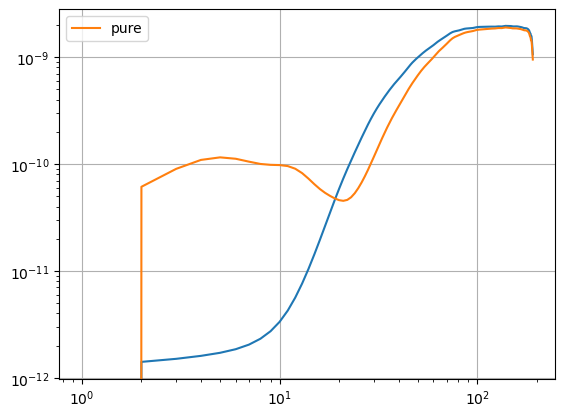

In [41]:
plt.plot(cl_noise[2])
plt.plot(cl_noise_pure[2], label='pure')
plt.loglog()
plt.grid()
plt.legend()

In [42]:
w = nmt.NmtWorkspace()
f = nmt.NmtField(mask_apo, np.empty((1, npix)), beam=bl*np.sqrt(fl))
w.compute_coupling_matrix(f, f, b)
bpw = w.get_bandpower_windows()[0,:,0]

w2 = np.sum(mask_apo**2)/np.sum(mask)
w4 = np.sum(mask_apo**4)/np.sum(mask)

nu_l = (2*np.arange(lmax+1)+1)*fsky*w2**2/w4*bin_size*fl
knox = (bpw@ (input_cls[2] + noise_cls[2]/bl**2)) * np.sqrt(2/(bpw@nu_l))

/tmp/ipykernel_40391/982265218.py:10: RuntimeWarning: invalid value encountered in sqrt
  knox = (bpw@ (input_cls[2] + noise_cls[2]/bl**2)) * np.sqrt(2/(bpw@nu_l))


In [43]:
#Test the purification
bin_size = 16
b = nmt.NmtBin.from_nside_linear(nside, bin_size)
ells = b.get_effective_ells()
c2db = ells * (ells+1) /2/np.pi

nmc = 128

cl = np.zeros((nmc, len(ells)))
cl_pure = np.zeros((nmc, len(ells)))

for i in tqdm(range(nmc)):
    # np.random.seed(i)
    signal = hp.synfast(input_cls, nside, fwhm=fwhm, new=True)
    # signal = hp.synfast(input_cls_noEE, nside, fwhm=fwhm, new=True)
    # signal = hp.synfast(input_cls_noBB, nside, fwhm=fwhm, new=True)
    # np.random.seed(i+1)
    noise = hp.synfast(noise_cls, nside, new=True)
    m = signal + noise

    obs_QU_unapo = (R_QU_unapo @ m[1:].flatten()).reshape(2, npix)
    # obs_QU_unapo = m[1:]
    f = nmt.NmtField(mask_apo, mask*obs_QU_unapo, beam=bl*np.sqrt(fl), purify_b=True)
    cl[i] = nmt.compute_full_master(f, f, b, cl_noise_pol)[3]
    # cl[i] = nmt.compute_full_master(f, f, b)[3]



    obs_QU = R_QU @ m[1:].flatten()
    pure_QU =  pi_b @ obs_QU
    
    f = nmt.NmtField(mask_apo, mask*pure_QU.reshape(2, npix), beam=bl*np.sqrt(fl_pure), masked_on_input=True)
    cl_pure[i] = nmt.compute_full_master(f, f, b, cl_noise_pure_pol)[3] 
    # cl_pure[i] = nmt.compute_full_master(f, f, b)[3] 


mean = np.mean(cl, axis=0)
std = np.std(cl, axis=0)

mean_pure = np.mean(cl_pure, axis=0)
std_pure = np.std(cl_pure, axis=0)

100%|████████████████████████████████████████████| 128/128 [00:36<00:00,  3.48it/s]


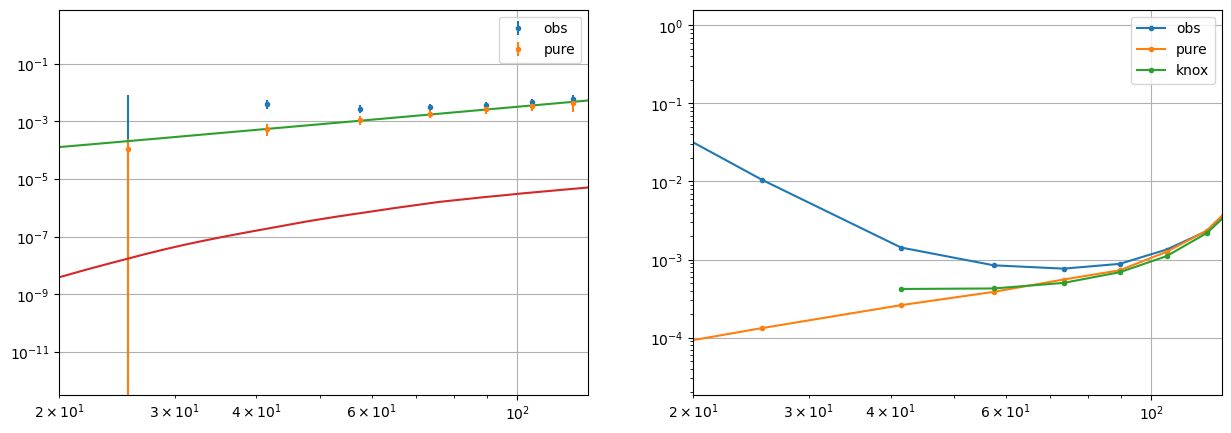

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].errorbar(ells, c2db*mean, c2db*std, fmt='.', label='obs')
axes[0].errorbar(ells, c2db*mean_pure, c2db*std_pure, fmt='.', label='pure')
axes[0].plot(c2d*input_cls[2])

axes[0].plot(c2d*cl_noise_pol[3])

axes[1].plot(ells, c2db*std, marker='.', label='obs')
axes[1].plot(ells, c2db*std_pure, marker='.', label='pure')
axes[1].plot(ells, c2db*knox, marker='.', label='knox')

for ax in axes.flatten():
    ax.set_xlim([20, 2*nside])
    ax.loglog()
    # ax.semilogy()
    ax.legend()
    ax.grid()